In [76]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from results import MCMCResults


m = MCMCResults.from_stsp_cat('/local/tmp/osg/2016october/hat11/cat_outputs', 172)

In [66]:
len(m.radius_chains)

300

(array([   18.,    62.,   106.,    55.,    31.,    62.,    44.,    73.,
           36.,  3388.]),
 array([   2.61483182,   38.34009856,   74.0653653 ,  109.79063204,
         145.51589877,  181.24116551,  216.96643225,  252.69169898,
         288.41696572,  324.14223246,  359.8674992 ]),
 <a list of 10 Patch objects>)

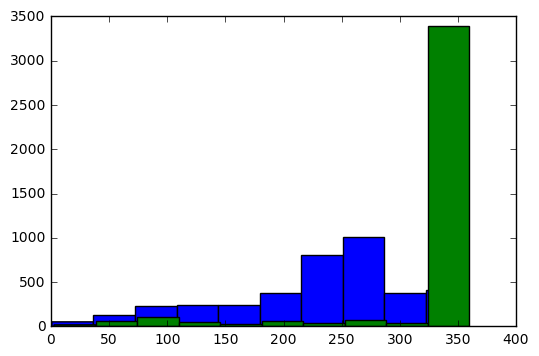

In [41]:
phi = m.phi_chains[0][:, 0]

import sys
sys.path.insert(0, '/astro/users/bmmorris/git/friedrich')
from friedrich.lightcurve import hat11_params_morris
from astropy.coordinates import Angle
import astropy.units as u

transit_params = hat11_params_morris()

def get_phis_unrolled(phi, light_curve, transit_params):
    lon1 = (phi + 2 * np.pi * (light_curve.times.jd.mean() - transit_params.t0) /
            transit_params.per_rot)

    lon2 = Angle(lon1, unit=u.rad).wrap_at(2*np.pi*u.rad)
    return lon2
    
lon2 = get_phis_unrolled(m.phi_chains[0][:,0], m.light_curve, transit_params)
plt.hist(lon2.deg)

    
lon2 = get_phis_unrolled(m.phi_chains[0][:,1], m.light_curve, transit_params)
plt.hist(lon2.deg)

In [75]:
!ls plots

animate		 discard_044.png  discard_172.png      tmp
animation.gif	 discard_049.png  north_up.png
discard_033.png  discard_076.png  north_up_no_inc.png


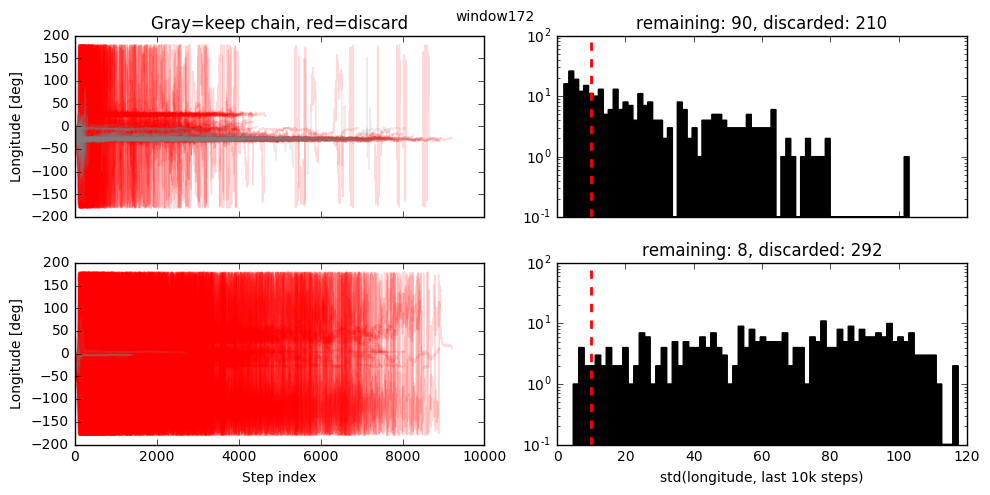

In [81]:
std_threshold = 10

spot_longitude_stds = [[] for i in range(m.phi_chains[0].shape[1])]
n_good_walkers = [0 for i in range(m.phi_chains[0].shape[1])]
walker_is_good = [True for i in range(len(m.phi_chains))]

fig, ax = plt.subplots(m.phi_chains[0].shape[1], 2, figsize=(10, 5), sharex='col')
for i in range(len(m.phi_chains)):
    for j in range(m.phi_chains[i].shape[1]):
        longitudes = get_phis_unrolled(m.phi_chains[i][:, j], m.light_curve, transit_params)
        
        lon = longitudes.deg
        lon[lon > 180] -= 360
        
        std = np.nanstd(lon[-10000:])

        spot_longitude_stds[j].append(std if not np.isnan(std) else 0)

        is_good = std < std_threshold

        ax[j, 0].plot(lon, alpha=0.15, color='gray' if is_good else 'r', zorder=-10 if is_good else None)
        
        n_good_walkers[j] += int(is_good)
        
        walker_is_good[i] &= is_good

# ax[0, 1].hist(spot_0_longitude_std, 70, log=True, histtype='stepfilled', color='k')
# ax[1, 1].hist(spot_1_longitude_std, 70, log=True, histtype='stepfilled', color='k')

for j in range(m.phi_chains[i].shape[1]):
    ax[j, 1].hist(spot_longitude_stds[j], 70, log=True, histtype='stepfilled', color='k')
    ax[j, 1].axvline(std_threshold, lw=2, ls='--', color='r')

    ax[j, 0].set_ylabel('Longitude [deg]')

    ax[j, 1].set_title('remaining: {0}, discarded: {1}'
                       .format(n_good_walkers[j], 
                               len(m.phi_chains)-n_good_walkers[j]))
    
ax[-1, 0].set_xlabel('Step index')
ax[-1, 1].set_xlabel('std(longitude, last 10k steps)')

ax[0, 0].set_title('Gray=keep chain, red=discard')

fig.suptitle('window{0:03d}'.format(m.window_ind))
fig.tight_layout()

fig.savefig('plots/discard_{0:03d}.png'.format(m.window_ind), bbox_inches='tight', dpi=200)

plt.show()

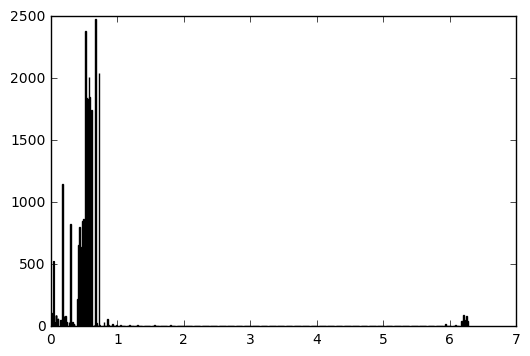

In [87]:
walker_is_good = np.array(walker_is_good)

plt.hist([m.phi_chains[i] for i, b in enumerate(walker_is_good) if b], 50);